### Clone the PsychRNN repositories and load the psychRNN package




In [5]:
!git clone -b DLPFC https://github.com/trustyuke/PsychRNN

Cloning into 'PsychRNN'...
remote: Enumerating objects: 1757, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 1757 (delta 85), reused 86 (delta 75), pack-reused 1638
Receiving objects: 100% (1757/1757), 76.95 MiB | 20.38 MiB/s, done.
Resolving deltas: 100% (679/679), done.


In [6]:
%cd /content/PsychRNN/
%ls

/content/PsychRNN
docs/                PsychRNN/                   test_checker_basic.ipynb
firingRateAnalysis/  README.md                   test_dlpfc319.ipynb
__init__.py          rec_Connectivity1_11.ipynb  testTask.ipynb
LICENSE              setup.py                    worklog/
psychrnn/            test/


In [7]:
# check a previous PMD rnn to see whether correct choice also change to 0 after choice

import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.dlpfc.basic2 import Basic2

from psychrnn.backend.dlpfc.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerDLPFC import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


### Initialize the task 
First we define some global parameters that we will use when setting up the task and the model:

In [8]:
experiment = 'interactive'
name = 'basic'
dt = 10 # The stimulaiton timestep
tau = 50 # The intrinsic time constant of neural state decay
T = 5000 # the trial length
N_batch = 50 #
N_rec = 100

dt = 10 # The simulation timestep.
tau = 100 # The intrinsic time constant of neural state decay.
T = 2000 # The trial length.
N_batch = 50 # The number of trials per training update.
N_rec = 50 # The number of recurrent units in the network.
name = 'basicModel' #  Unique name used to determine variable scope for internal use.



# Generate a batch of trials with linear gain

In [9]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, noise = 0.25, accumulation_mask = 0, wait = 0)

In [10]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 2,
 'N_out': 1,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [-0.9, 0.9],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 0,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0,
 'hi': 1,
 'lo': 0}

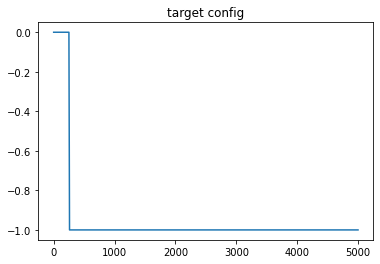

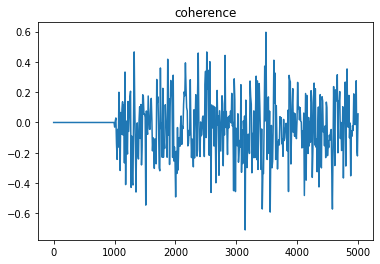

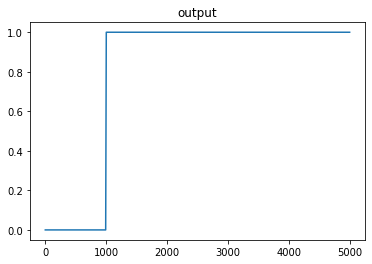

-0.02966912484150941


In [11]:
#### must check RT and time step 

[x, y, mask, allParams] = task.get_trial_batch()

trialNum = 2
# x[1]: left tartet evidence
# x[2]: right target evidence
trialIn = x[trialNum,:,0:2]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot target configuration (-1: RL&GR 1: RR&GL)
plt.figure()
plt.plot(time, trialIn[:,0])
plt.title("target config")

# plot input coherence (positive: red negative: green)
plt.figure()
plt.plot(time, trialIn[:,1])
plt.title("coherence")

# plot output to the model (0: left 1: right)
plt.figure()
plt.plot(time, trialOut[:,0])
plt.title("output")

# plot trial masks
# plt.figure()
# plt.plot(time, trialMask[:,0])

plt.show()

print(allParams[trialNum]['coherence'])

# Set Network params

In [12]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
# network_params["output_transfer_function"] = tf.nn.sigmoid
network_params["output_transfer_function"] = tf.nn.tanh

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [13]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [14]:
# check model
# vars(model)

# a = model.get_weights()
# a.keys()

In [15]:
# vars(model)

# Set Training params & Train

In [16]:
trials = 20000
train_params = {}
train_params['save_weights_path'] =  "./checkerDLPFCTest"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [17]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./checkerDLPF2CTest.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Iter 500, Minibatch Loss= 0.427310
Iter 1000, Minibatch Loss= 0.391474
Iter 1500, Minibatch Loss= 0.382744
Iter 2000, Minibatch Loss= 0.365465
Iter 2500, Minibatch Loss= 0.399503
Iter 3000, Minibatch Loss= 0.458992
Iter 3500, Minibatch Loss= 0.496441
Iter 4000, Minibatch Loss= 0.457371
Iter 4500, Minibatch Loss= 0.378232
Iter 5000, Minibatch Loss= 0.417669
Iter 5500, Minibatch Loss= 0.405498
Iter 6000, Minibatch Loss= 0.369466
Iter 6500, Minibatch Loss= 0.418782
Iter 7000, Minibatch Loss= 0.398776
Iter 7500, Minibatch Loss= 0.361448
Iter 8000, Minibatch Loss= 0.639572
Iter 8500, Minibatch Loss= 0.707514
Iter 9000, Minibatch Loss= 0.514518
Iter 9500, Minibatch Loss= 0.388315
Iter 10000, Minibatch Loss= 0.396037
Iter 10500, Minibatch Loss= 0.364566
Iter 11000, Minibatch Loss= 0.358473
Iter 11500, Minibatch Loss= 0.358350
Iter 12000, Minibatch Loss= 0.351051
Iter 12500, Minibatch Loss= 0.397739
Iter 13000, Minibatch Loss= 0.376103
Iter 13500, Minibatch Loss= 0.354887
Iter 14000, Minibatch

# Test 5000 trials

In [18]:
trials =5000
batches = int(np.ceil(trials / N_batch))


rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

configuration = np.zeros(trials) 
coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

correct_side = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)


In [19]:
for b in tqdm(range(batches)):
    [x, y, mask, params] = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    


    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        configuration[index] = params[i]["side"]
        correct_side[index] = y[i,499,:]
        
        
        ############ must change how decision is calculated  
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        
        if (np.sum(outputs[i,:,:] > 0.7) != 0):
            decision[index] = 1
            temp = np.where(outputs[i,:,:] > 0.7)
            rt[index] = temp[0][0]*task.dt - target_onset[index] - checker_onset[index] 
        elif (np.sum(outputs[i,:,:] < -0.7) != 0):
            decision[index] = -1
            temp = np.where(outputs[i,:,:] < -0.7)
            rt[index] = temp[0][0]*task.dt - target_onset[index] - checker_onset[index]             

        else:
            decision[index] = 0
            rt[index] = T - target_onset[index] - checker_onset[index]

            
                
            
#         decision[index] = thr_unit



100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


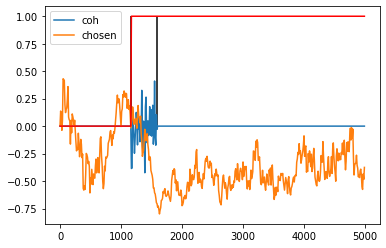

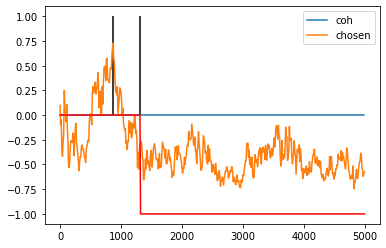

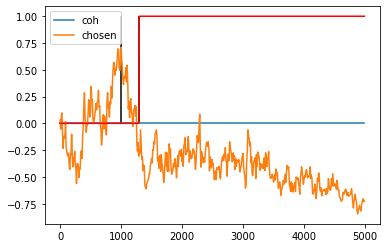

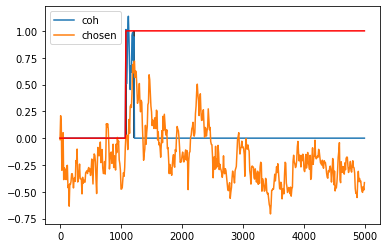

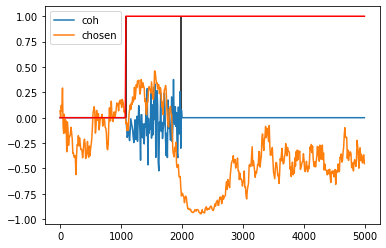

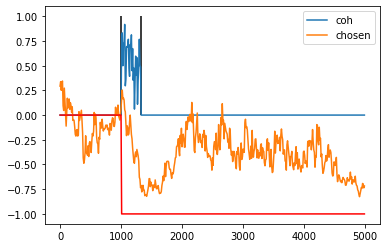

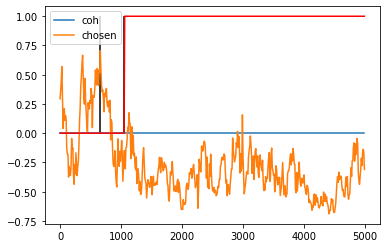

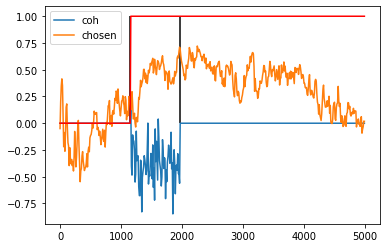

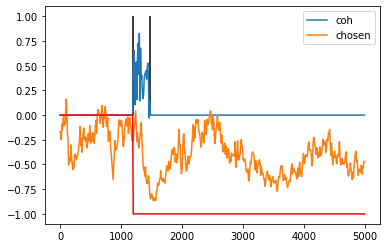

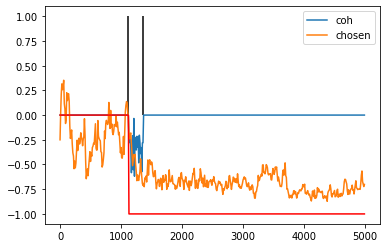

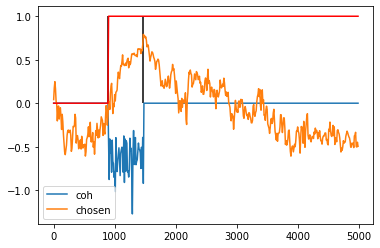

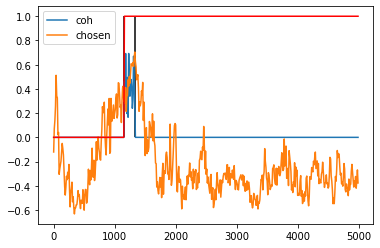

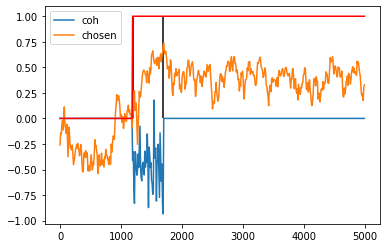

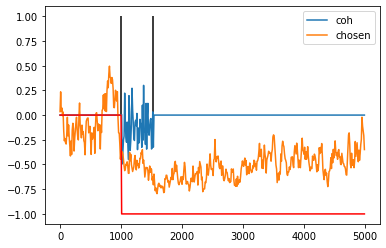

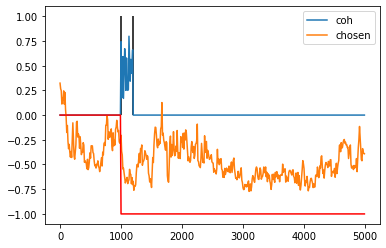

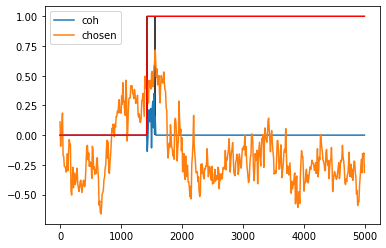

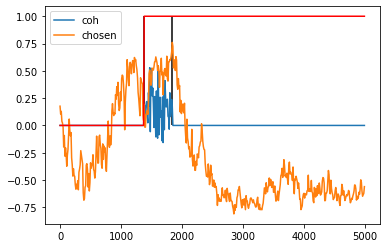

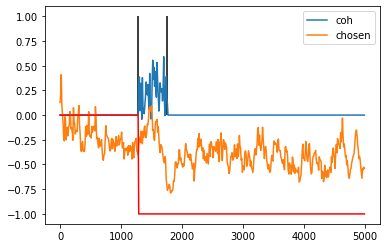

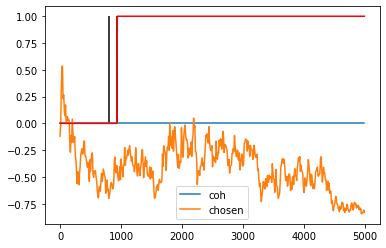

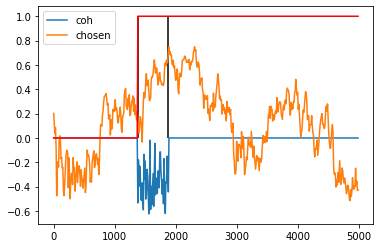

In [20]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(0,20):
    plt.figure()
#     plt.plot(np.arange(0, T, 10), inputs[i, :, 0], label = 'config')
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1], label = 'coh')
    
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0], label = 'chosen')
    plt.legend()
    
    plt.plot(np.arange(0, T, 10), y[i, :, 0], label = 'correct', color = 'r')
    
    
    plt.vlines(onsets[i], 0, 1, color = 'k')
    plt.vlines(onsets[i] + rts[i], 0, 1, color = 'k')
#     plt.figure()
#     plt.plot(np.arange(0, T, 10), g[i])

In [21]:

checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                          'configuration' : configuration})



print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))



Overall Accuracy: 0.8888
Negative RT trials ratio: 0.1566


In [22]:
# checker_df


# chosen color: 1 (red); -1 (green)
chosen_color = np.zeros([len(checker_df),1])
for i in range(len(checker_df)):
    if(checker_df.configuration[i] == -1 and checker_df.decision[i] == -1):
        chosen_color[i] = 1
    if(checker_df.configuration[i] == -1 and checker_df.decision[i] == 1):
        chosen_color[i] = -1        
    if(checker_df.configuration[i] == 1 and checker_df.decision[i] == -1):  
        chosen_color[i] = -1        
    if(checker_df.configuration[i] == 1 and checker_df.decision[i] == 1):        
        chosen_color[i] = 1        
        
checker_df["chosen_color"] = chosen_color

checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


#######################
## summary result save path

resultPath = "./checkerDLPFCTest.csv"
checker_df.to_csv(resultPath)

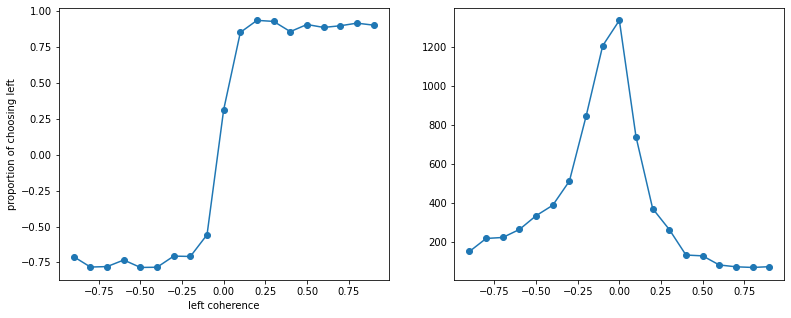

In [23]:
# psychrometric curve 
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['chosen_color'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['chosen_color'])
plt.xlabel("left coherence")
plt.ylabel("proportion of choosing left")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



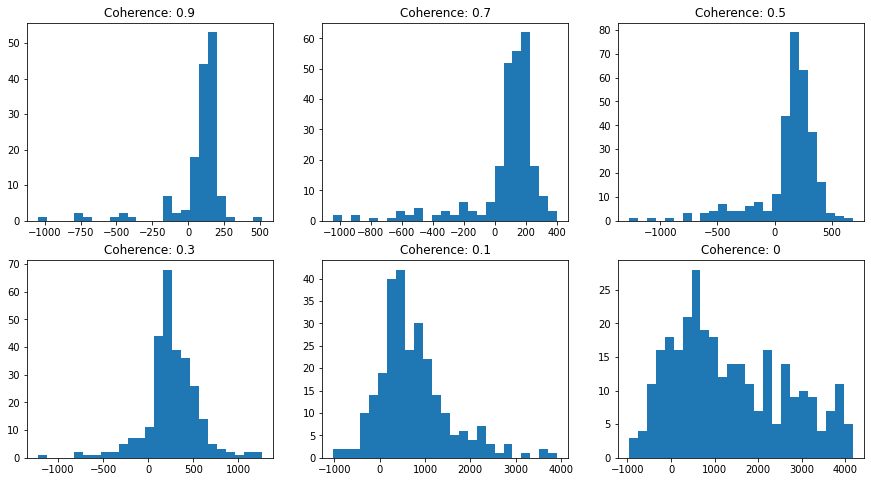

In [24]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

IndexError: ignored

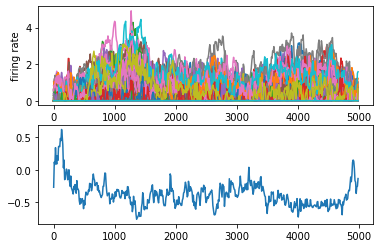

In [25]:
trial_num = 50
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()

In [ ]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("temp.mat", mdic)

In [ ]:
model.destruct()